<h1> Ferrero interview take-home project

Since there was no column meaning explanation given I will use this markdown cell to write down the column meanings as I understand them, so there is a consistency for the readers as they go through the notebook

<b>Loan_ID</b>: Uniquely indentifies the number of the loan case

<b>Gender</b>: The gender of the applicant

<b>Married</b>: The marital status

<b>Dependents</b>: The number of children in the family

<b>Education</b>: The level of education of the applicant

<b>Self_Employed</b>: Is the applicant self-employed?

<b>ApplicantIncome</b>: Applicants income (assuming monthly)

<b>CoapplicantIncome</b>:  Co-applicants income (assuming monthly)

<b>LoanAmount</b>: The loan amount (assuming thousands)

<b>Loan_Amount_Term</b>: How long they will be paying off the loan (assuming months)

<b>Credit_History</b>: The creditworthiness of the applicant.

<b>Property_Area</b>: Where the applicant resides.

<b>Loan_Status</b>: The decision for the loan application

---------------------------------------

In [374]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer

In [375]:
df_train = pd.read_csv('loan_sanction_train.csv')
df_test = pd.read_csv('loan_sanction_test.csv')

<h1> Excercise 1

<h3>Questions 1-2 ~ Data observe

In [376]:
df = df_train.copy()

display('columns and rows:', df.shape, df.head(5))

'columns and rows:'

(614, 13)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [377]:
print("Column types of df:")
print(df.dtypes)

Column types of df:
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object


In [378]:
def check_for_odd_values(data):
    """Sometimes searching for null is not enough 
    as there have been cases of finding hardcoded 'null' strings in the data 
    or irrelevant words especially in non-validated data systems
    I will use this ugly function just once to check the values of each column for wrong inputs
    and check for some inconsistencies
    """
    #Check for duplicates
    if data.duplicated(keep=False).sum() == 0:
        print('no duplicated rows')

    #Values check
    data = data.dropna()
    unique_ID = data['Loan_ID'].is_unique
    married = data['Married'].nunique()
    education = data['Education'].nunique()
    self_employed = data['Self_Employed'].nunique()
    credit = data['Credit_History'].nunique()
    label = data['Loan_Status'].nunique()

    
    if unique_ID and education == married == credit == label == 2:
        print('binary columns passed')
    print('')
    print('property area: ', data['Property_Area'].unique())
    print('dependents: ', data['Dependents'].unique())
    print('gender: ', data['Gender'].unique())
    print('')
    
    #Outliers
    threshold = 1.5
    for column in df.select_dtypes(include=['number']):
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        if not outliers.empty:
            print(f"Outliers detected in column '{column}':")
    
check_for_odd_values(df)

no duplicated rows
binary columns passed

property area:  ['Rural' 'Urban' 'Semiurban']
dependents:  ['1' '0' '2' '3+']
gender:  ['Male' 'Female']

Outliers detected in column 'ApplicantIncome':
Outliers detected in column 'CoapplicantIncome':
Outliers detected in column 'LoanAmount':
Outliers detected in column 'Loan_Amount_Term':
Outliers detected in column 'Credit_History':


Except for the null values the other inputs of the dataset seem valid.
There is an indication for outliers but we will examine it better with visualizations later

------------------------------------------

<h2>Question 3-4 ~ Handling Null Values

In [379]:
null_percentage = df.isnull().mean() * 100
null_percentage = round(null_percentage, 2)
 
null_counts = df.isnull().sum()
null_info = pd.DataFrame({'Percentage': null_percentage, 'Null Count': null_counts})

print("Null values in each column:")
print(null_info[null_info['Null Count'] > 0])

Null values in each column:
                  Percentage  Null Count
Gender                  2.12          13
Married                 0.49           3
Dependents              2.44          15
Self_Employed           5.21          32
LoanAmount              3.58          22
Loan_Amount_Term        2.28          14
Credit_History          8.14          50


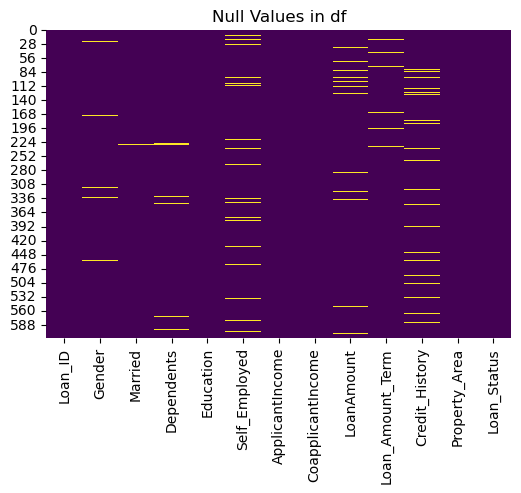

In [380]:
plt.figure(figsize=(6, 4))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title('Null Values in df')
plt.show()

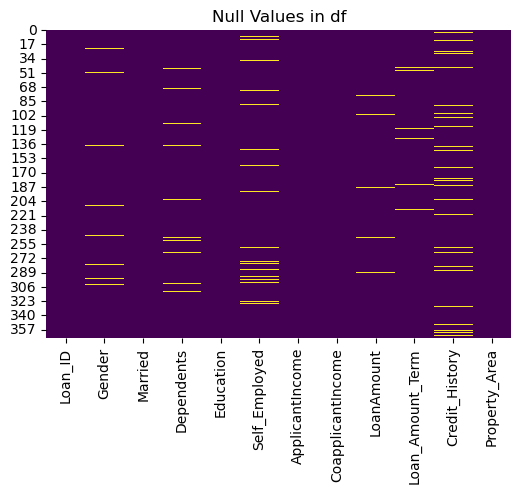

In [381]:
plt.figure(figsize=(6, 4))
sns.heatmap(df_test.isnull(), cmap='viridis', cbar=False)
plt.title('Null Values in df')
plt.show()

<h5> Lets examine ways to address the null values problem

1. Deletion: Remove rows or columns with null values. This is suitable when the null values are relatively few compared to the total dataset and removing them won't significantly affect the analysis.

In [382]:
1 - df.dropna().shape[0] / df.shape[0] 

0.21824104234527686

As anyone can see deleting all rows containing null values results in deleting around 22% of our dataset. This is a large percentage, especially for this dataset which is relatively small in the first place

2. Forward or Backward Fill: Use the value from the previous or next row to fill null values

This is a technique that should be used in othe types of dataset such us time series where the data of the previous row is highly associated with the next one

3. Predictive Modeling: Use machine learning algorithms to predict missing values based on other features in the dataset.

Basically the scope is to train a model to predict the missing values based on other features in the data. For example KNN imputation. I would like to give this a a shot but maybe it exceeds the scope of the porject.

4. Statistical Imputation: Replace null values with a suitable substitute, such as the mean, median, mode, or a constant value.
   In order to be in place to determine a substitute strategy we should take a quick look to the distributions of the null columns.

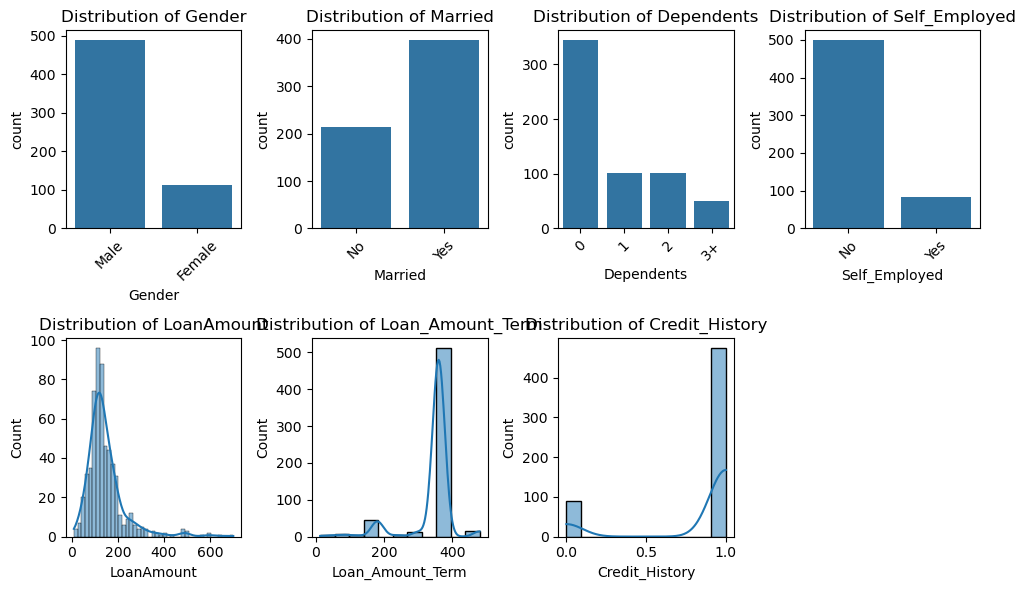

In [383]:
columns_with_nulls = [col for col in df.columns if df[col].isnull().any()]
df_without_id = df.drop('Loan_ID', axis =1)

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

    num_cols = 4 
    num_rows = (len(columns_with_nulls) + num_cols - 1) // num_cols 

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3*num_rows))
    axes = axes.flatten()

    for i, col in enumerate(df[columns_with_nulls]):
        if df_without_id[col].dtype == 'object':
            sns.countplot(data=df_without_id, x=col, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].tick_params(axis='x', rotation=45)
        else:
            sns.histplot(data=df_without_id, x=col, kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')

    # Hide the empty
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Most of the categorical columns have a dominant class and I believe it is a good approach to follow the "most frequent" strategy. 
Similarly I will impute the numerical columns with the mean value.

In [384]:
def fixNull(df):
    null_categorical_cols = list(df[columns_with_nulls].select_dtypes(include=['object']).columns)
    null_numerical_cols = list(df[columns_with_nulls].drop(['Credit_History', 'Loan_Amount_Term'], axis=1).select_dtypes(include=['float64', 'int64']).columns) # I should treat credit history separately
    
    # Categorical Impute
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[null_categorical_cols] = cat_imputer.fit_transform(df[null_categorical_cols])
    
    # Numerical Impute
    num_imputer = SimpleImputer(strategy='mean')
    df[null_numerical_cols] = num_imputer.fit_transform(df[null_numerical_cols])
    
    
    # Loan Amount Term
    df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
    df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

    return df

df = fixNull(df)
df_test = fixNull(df_test)

For the credit history I suspect that it is the most prominent feature and highly correlated with the target so I will try a predictive imputation that 
will consider the relationships of the 'Credit Historly' column with other columns in the dataset based on distance metrics, and accordingly it will impute it.

In [385]:
# # Credit History Impute
# imputer = KNNImputer(n_neighbors=5, weights="distance", metric="nan_euclidean", strategy="most_frequent")
# df['Credit_History'] = imputer.fit_transform(df[['Credit_History']])

In [386]:
if df.isnull().sum().sum()==0:
    print('Imputed successfully, no null found')

if df_test.isnull().sum().sum()==0:
    print('Imputed successfully, no null found')

Imputed successfully, no null found
Imputed successfully, no null found


The dataset is null-free, so lets do some basic EDA to get a closer view to the data

In [387]:
# Loan_ID is no usefull to the analysis
df.drop(columns=['Loan_ID'], inplace=True)

categorical_cols = list(df.select_dtypes(include=['object']).columns)
numerical_cols = list(df.select_dtypes(include=['float64', 'int64']).columns)

print('categorical', categorical_cols)
print('numerical', numerical_cols)

categorical ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']
numerical ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


<h2> EDA

<h3> Outlier detection

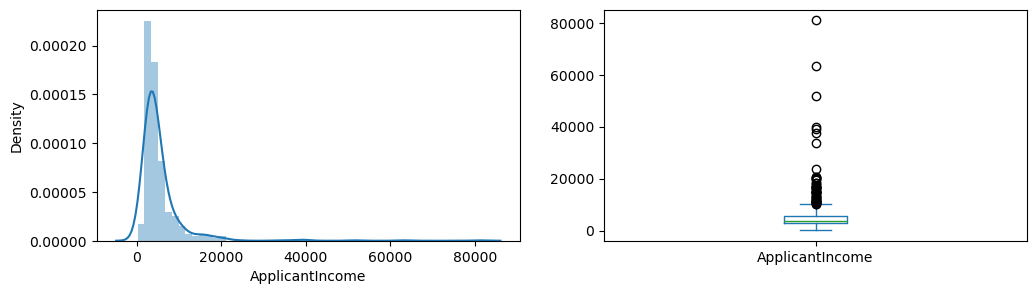

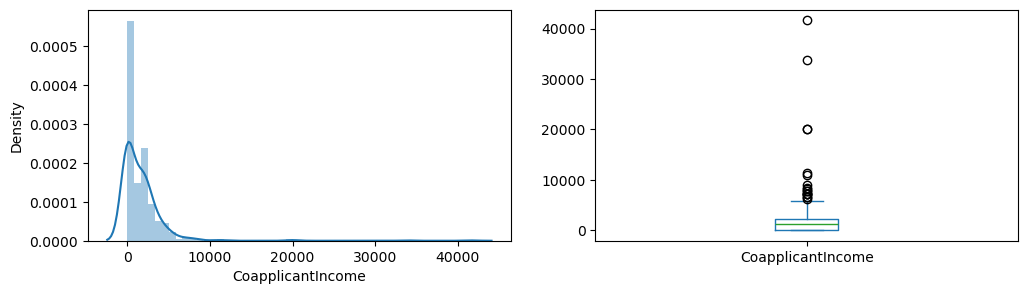

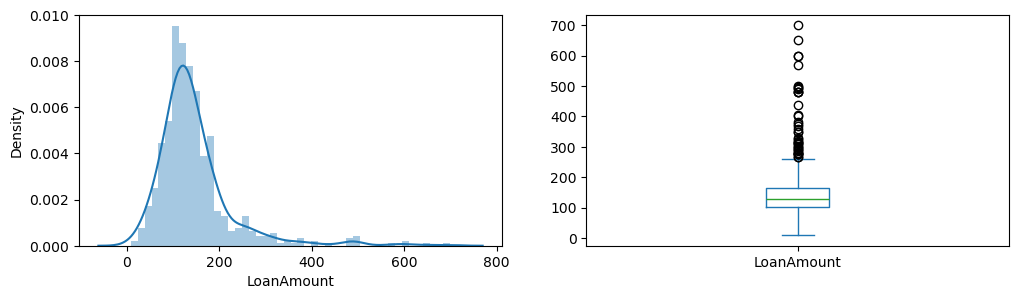

In [388]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

    plt.subplot(121)
    sns.distplot(df['ApplicantIncome']);
    
    plt.subplot(122)
    df['ApplicantIncome'].plot.box(figsize=(12,3))
    plt.show()
    print('')
    
    plt.subplot(121)
    sns.distplot(df['CoapplicantIncome']);
    
    plt.subplot(122)
    df['CoapplicantIncome'].plot.box(figsize=(12,3))
    
    plt.show()
    print('')

    plt.subplot(121)
    sns.distplot(df['LoanAmount']);
    
    plt.subplot(122)
    df['LoanAmount'].plot.box(figsize=(12,3))
    
    plt.show()

It is visible through these graphs that all these 3 numerical variables contain outliers that may cause trouble at the model section. 
The distribution is right-skewed (positive skewness) especially in the 2 incomes variables. We will deal with that before the model part

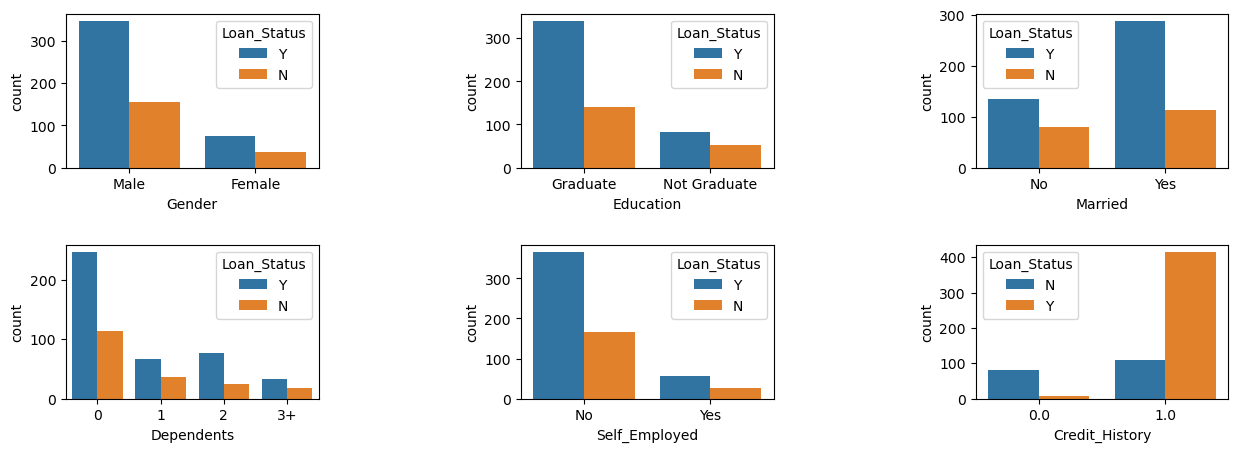

In [389]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.8, hspace=0.5) 
plt.subplot(231)
sns.countplot(df, x="Gender" , hue="Loan_Status");

plt.subplot(232)
sns.countplot(df, x="Education" , hue="Loan_Status");

plt.subplot(233)
sns.countplot(df, x="Married" , hue="Loan_Status");

plt.subplot(234)
sns.countplot(df, x="Dependents" , hue="Loan_Status");

plt.subplot(235)
sns.countplot(df, x="Self_Employed" , hue="Loan_Status");

plt.subplot(236)
sns.countplot(df, x="Credit_History" , hue="Loan_Status");

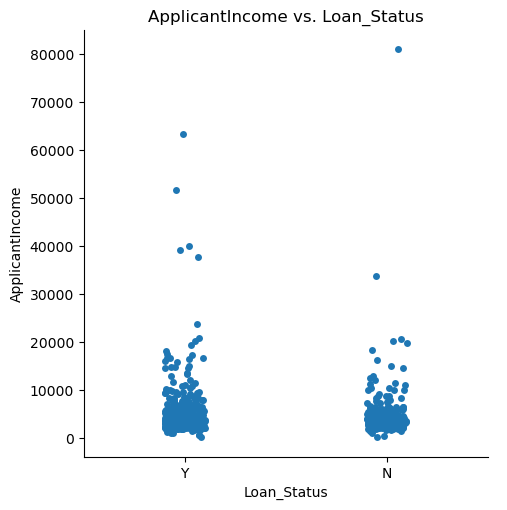

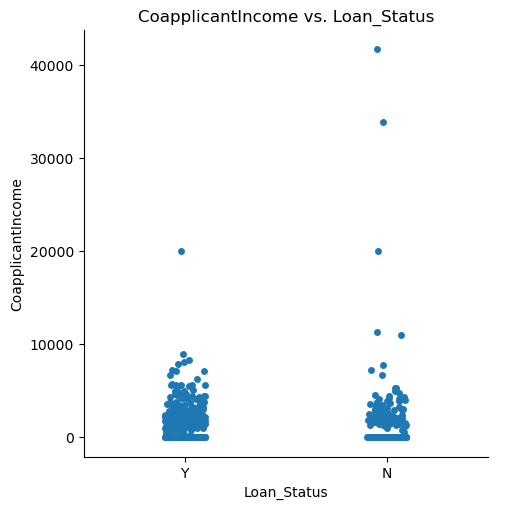

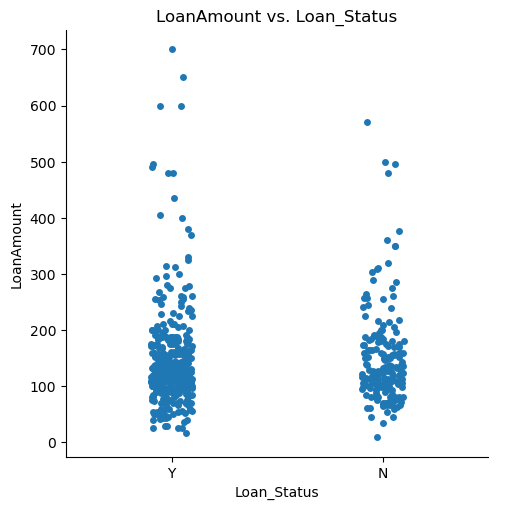

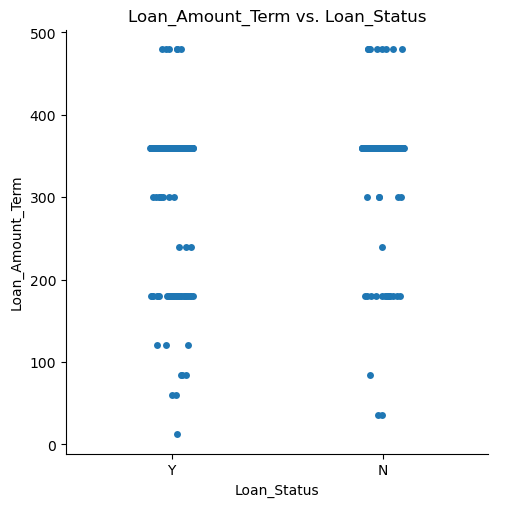

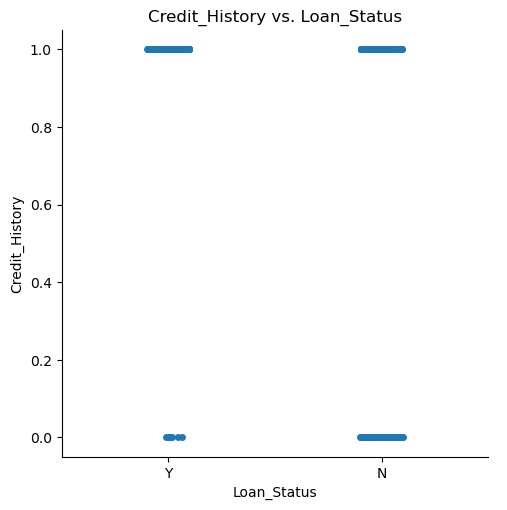

In [390]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    for col in numerical_cols:
        sns.catplot(data=df_without_id, x='Loan_Status', y=col)
        plt.title(f'{col} vs. Loan_Status')
        plt.show()

Outlier Treatment

In [391]:
def log_variables(x):
    if x>0:
        return np.log(x)
    else:
        return 0

columns_with_outliers = ['LoanAmount', 'ApplicantIncome', 'CoapplicantIncome']

df[columns_with_outliers] = df[columns_with_outliers].applymap(log_variables)
df.rename(columns={col: col + '_log' for col in columns_with_outliers}, inplace=True)

df_test[columns_with_outliers] = df_test[columns_with_outliers].applymap(log_variables)
df_test.rename(columns={col: col + '_log' for col in columns_with_outliers}, inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8632\4064853709.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns_with_outliers] = df[columns_with_outliers].applymap(log_variables)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8632\4064853709.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_test[columns_with_outliers] = df_test[columns_with_outliers].applymap(log_variables)


In [392]:
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,8.674026,0.000000,4.986426,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,8.430109,7.318540,4.852030,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,8.006368,0.000000,4.189655,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,7.856707,7.765569,4.787492,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,8.699515,0.000000,4.948760,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,7.972466,0.000000,4.262680,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,8.320205,0.000000,3.688879,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8.996157,5.480639,5.533389,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,8.933664,0.000000,5.231109,360.0,1.0,Urban,Y


<h3>Questions 6-10

In [393]:
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Display the shape of the training and validation sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Training set shape: (552, 11) (552,)
Validation set shape: (62, 11) (62,)


In [394]:
df_test.drop('Loan_ID', axis=1, inplace = True)

When specifying a random seed the split method uses this values to  generate random indices for splitting the data into training and validation sets. 
This ensures that the random numbers generated by this code will be reproducible in future runs

Here I will re-set the variables in the 2 lists

In [396]:
numerical_cols = ['ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log']
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Amount_Term', 'Credit_History']



# Define preprocessing steps
#numerical_transformer = MinMaxScaler()
numerical_transformer = StandardScaler()
#categorical_transformer = OneHotEncoder(handle_unknown='ignore')
categorical_transformer = OrdinalEncoder()

# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Create a preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform the preprocessing pipeline on the training data
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)

# Transform the validation data using the fitted preprocessing pipeline
X_val_preprocessed = preprocessing_pipeline.transform(X_val)

X_test_preprocessed = preprocessing_pipeline.fit_transform(df_test)


In [397]:
X_test_preprocessed.shape

(367, 11)

In [400]:
def rf_model(gridSearch, metric):
    
    with warnings.catch_warnings():
         warnings.filterwarnings('ignore')

         if gridSearch:
             
             
             param_grid = {
             'n_estimators': [20, 50, 100],
             'max_depth': [2, 4, 6],
             'min_samples_split': [2, 5, 8],
             'min_samples_leaf': [2, 4],
             }
  
             rf_model = RandomForestClassifier(random_state=42)
    
             grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring=metric)
     
             grid_search.fit(X_train_preprocessed, y_train)
             best_params = grid_search.best_params_
             best_score = grid_search.best_score_
             print(best_params)
             rf_model = RandomForestClassifier(**best_params, random_state=42)
            
             
         else:
             rf_model = RandomForestClassifier(n_estimators=50, max_depth=8, min_samples_split=2, random_state=42)
             
             
    return rf_model




model = rf_model(False, 'accuracy')
model.fit(X_train_preprocessed, y_train)
y_train_pred = model.predict(X_train_preprocessed)
y_val_pred = model.predict(X_val_preprocessed)

In [401]:
print("Performance on the training set:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred, pos_label='Y'))
print("Recall:", recall_score(y_train, y_train_pred, pos_label='Y'))
print("F1-score:", f1_score(y_train, y_train_pred, pos_label='Y'))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred))

Performance on the training set:
Accuracy: 0.8786231884057971
Precision: 0.852017937219731
Recall: 0.9973753280839895
F1-score: 0.9189842805320436
Confusion Matrix:
[[105  66]
 [  1 380]]


In [402]:
print("\nPerformance on the validation set:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred, pos_label='Y'))
print("Recall:", recall_score(y_val, y_val_pred, pos_label='Y'))
print("F1-score:", f1_score(y_val, y_val_pred, pos_label='Y'))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


Performance on the validation set:
Accuracy: 0.7419354838709677
Precision: 0.7358490566037735
Recall: 0.9512195121951219
F1-score: 0.8297872340425531
Confusion Matrix:
[[ 7 14]
 [ 2 39]]


In [410]:
pred1 = model.predict(X_test_preprocessed)

In [414]:
pred1

array(['N', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y',
       'N', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N',
       'N', 'N', 'N', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y',
       'Y', 'Y', 'N', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'N',
       'Y', 'N', 'N', 'N', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'N', 'N', 'Y', 'N', 'N', 'N', 'Y', 'Y', 'N', 'Y', 'N', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'N', 'N', 'Y',
       'Y', 'Y', 'N', 'Y', 'N', 'N', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y',
       'N', 'N', 'N', 'N', 'Y', 'Y', 'N', 'N', 'N', 'N', 'N', 'Y', 'Y',
       'Y', 'N', 'Y', 'N', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'Y', 'N',
       'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'N', 'N', 'N', 'Y',
       'Y', 'N', 'Y', 'N', 'N', 'N', 'N', 'N', 'Y', 'N', 'N', 'Y', 'N',
       'N', 'N', 'N', 'N', 'N', 'N', 'Y', 'Y', 'N', 'N', 'Y', 'Y

In [404]:
rf_model_cv = RandomForestClassifier(n_estimators=50, max_depth=8, min_samples_split=2, random_state=42)

In [405]:
X_preprocessed = preprocessing_pipeline.fit_transform(X)

In [406]:
#custom_accuracy_scorer = make_scorer(accuracy_score, pos_label='Y')
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model_cv, X_preprocessed, y, cv=kf, scoring='accuracy')
print("Cross-Validation Scores (Accuracy):", cv_scores)
print("Average Accuracy:", cv_scores.mean())

Cross-Validation Scores (Accuracy): [0.7804878  0.81300813 0.82926829 0.78861789 0.81147541]
Average Accuracy: 0.8045715047314408


In [407]:
rf_model_cv.fit(X_preprocessed, y)

RandomForestClassifier(max_depth=8, n_estimators=50, random_state=42)

In [411]:
pred2 = rf_model_cv.predict(X_test_preprocessed)

In [409]:
y_pred_test

array(['Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y',
       'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'N',
       'Y', 'N', 'N', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'N', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y',
       'N', 'N', 'N', 'N', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N',
       'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'N', 'N', 'Y', 'N',
       'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y

In [416]:
differences_mask = pred1 != pred2
# Find indices where predictions are different
different_indices = np.where(differences_mask)[0]

# Print indices and corresponding predictions where differences occur
#for idx in different_indices:
#    print(f"Index {idx}: Method 1 Prediction - {pred1[idx]}, Method 2 Prediction - {pred2[idx]}")
different_indices.shape

(77,)

In [417]:
X_test.shape

(123, 10)

<h1> Excercise 2

In [178]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Perform any necessary data preprocessing (e.g., handling missing values, encoding categorical variables)

# Define the target variable (ApplicantIncome) and the independent variables (features)
X = df.drop(columns=["ApplicantIncome_log", "Loan_Status"])
y = df["ApplicantIncome_log"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.shape

(614, 10)

In [179]:
X_train.shape

(491, 10)

In [180]:
numerical_cols = ['CoapplicantIncome_log', 'LoanAmount_log']
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Amount_Term', 'Credit_History']



preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Create a preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])




X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)

X_test_preprocessed = preprocessing_pipeline.transform(X_test)

In [181]:
X_train

,Gender,Married,Dependents,Education,Self_Employed,CoapplicantIncome_log,LoanAmount_log,Loan_Amount_Term,Credit_History,Property_Area
83,Male,Yes,0,Graduate,No,7.718685,5.579730,360.0,1.0,Semiurban
90,Male,Yes,0,Graduate,No,7.972466,4.875197,360.0,1.0,Semiurban
227,Male,Yes,2,Graduate,No,7.435438,5.347108,360.0,1.0,Semiurban
482,Male,Yes,0,Graduate,No,8.055158,4.852030,360.0,1.0,Semiurban
464,Male,No,0,Graduate,No,0.000000,4.584967,360.0,0.0,Semiurban
...,...,...,...,...,...,...,...,...,...,...
71,Male,Yes,2,Not Graduate,Yes,7.536364,4.574711,360.0,1.0,Semiurban
106,Male,Yes,2,Graduate,No,7.026427,5.416100,360.0,1.0,Urban
270,Female,No,0,Graduate,No,0.000000,3.401197,360.0,1.0,Urban
435,Female,Yes,0,Graduate,No,0.000000,4.986426,240.0,1.0,Semiurban


In [182]:
# Train a linear regression model on the training data
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_preprocessed, y_train)

# Evaluate the model's performance on the testing data
y_pred = linear_reg_model.predict(X_test_preprocessed)


In [183]:
X.columns.shape

(10,)

In [184]:
linear_reg_model.coef_.shape

(10,)

In [207]:
absolute_errors = np.abs(y_test[:120] - y_pred[:120])
mean_absolute_error = np.mean(absolute_errors)
print(mean_absolute_error)
# Analyze the coefficients of the linear regression model
coefficients_prior = linear_reg_model.coef_
intercept = linear_reg_model.intercept_
feature_names = X.columns

coefficients_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

print(coefficients_df)
print("Intercept:", intercept)


0.3187060953846666
                 Feature  Coefficient
0                 Gender    -0.297157
1                Married     0.331883
2             Dependents     0.200575
3              Education     0.085658
4          Self_Employed     0.003652
5  CoapplicantIncome_log    -0.134806
6         LoanAmount_log     0.232683
7       Loan_Amount_Term    -0.008051
8         Credit_History    -0.014249
9          Property_Area     0.027012
Intercept: 8.235238251872872
